In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import shapiro
from statsmodels.formula.api import logit

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RepeatedKFold, GridSearchCV, cross_val_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.svm import SVC

from lightgbm import Dataset, cv as lgbm_cv, early_stopping, plot_importance as lgbm_plot_importance, train as lgbm_train, LGBMClassifier

import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

import warnings
warnings.filterwarnings('ignore')

# Введение

Классическая задача на бинарную классификацию. Буквально "Hello, world!" от мира Data Science.

# 1. Анализ данных.

Для начала загрузим наши данные и проведем первичный осмотр.

In [2]:
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Итак, что нам первым делом бросается в глаза? Мы имеем 12 признаков (один из которых является целевым) и 891 запись. Ряд признаков очевидно не несут в себе никакой статистической информации: 'PassengerId', 'Name', 'Ticket'. Признак 'Cabin', возможно, мог бы быть нам полезным (если мы предположим, что по номеру кабины можно определить, на какой палубе она находится), но этот признак содержит в себе слишком много пропусков. Также мы могли бы предположить, что пропуск в данной графе означает, что у пассажира не было своей каюты, но напрямую в описании данных это не указано, а заниматься гаданием мне бы не хотелось. Предлагаю, не откладывая в долгий ящик, удалить эти бесполезные признаки.

In [5]:
train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

Далее я предлагаю посмотреть на распределение числовых признаков. Числовых признаков у нас всего 4: 'Age', 'SibSp', 'Parch' и 'Fare'.

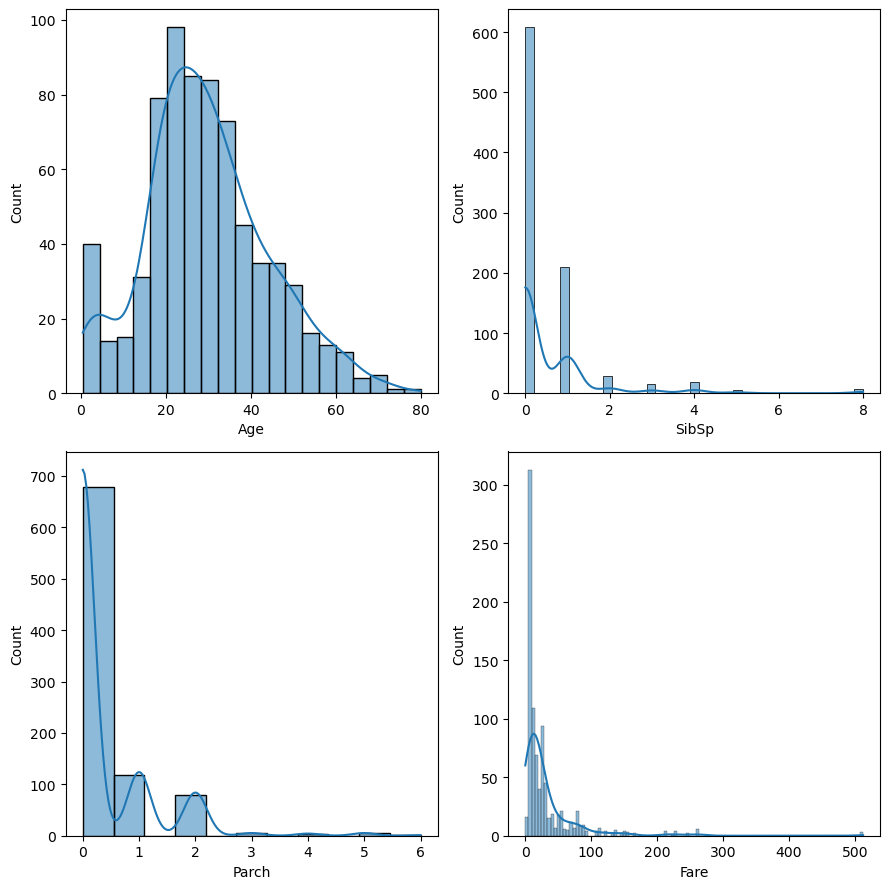

In [6]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(9, 9))
sns.histplot(train_data['Age'], kde=True, ax=axes[0][0])
sns.histplot(train_data['SibSp'], kde=True, ax=axes[0][1])
sns.histplot(train_data['Parch'], kde=True, ax=axes[1][0])
sns.histplot(train_data['Fare'], kde=True, ax=axes[1][1])
fig.tight_layout();

Что мы видим? Распределение признака 'Age' отдаленно напоминает нормальное, хотя и с явными искажениями. Распределение признака 'Fare' похоже на логнормальное. Распределения признаков 'SibSp' и 'Parch' не похоже вообще ни на что. Первый порыв - применить к данным признакам преобразования (например, логарифмическое или преобразование Бокса-Кокса), - но мы не будем спешить. Пока что просто возьмем эту мысль на заметку.

Далее я предлагаю заполнить пропуски в данных. Вообще, не очень правильно делать это сейчас, так как далее мы будем выделять из обучающей
выборки валидационную выборку, в которой мы допустим утечку данных, однако я считаю, что объем этой утечки будет не настолько большой, чтобы нам об этом беспокоиться (тем более, что в последствии мы эту ситуацию исправим). Предлагаю заполнить пропуски в признаке 'Age' медианой, а пропуски в признаке 'Embarked', очевидно, модой.

Кстати, а как обстоят дела с пропущенными значениями в тестовой выборке?

In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    418 non-null    int64  
 1   Sex       418 non-null    object 
 2   Age       332 non-null    float64
 3   SibSp     418 non-null    int64  
 4   Parch     418 non-null    int64  
 5   Fare      417 non-null    float64
 6   Embarked  418 non-null    object 
dtypes: float64(2), int64(3), object(2)
memory usage: 23.0+ KB


Имеется пропуск в признаке 'Fare' - его так же надо заполнить. В принципе, этот пропуск всего один, так что не имеет особого значения, какой статистикой мы его заполним, так как одна запись не сможет сильно исказить наши данные. Заполнять пропуск будем той же медианой.

Что ж, предлагаю приступить к исполнению нашего плана.

In [8]:
train_data['Age'] = train_data['Age'].fillna(train_data['Age'].median())
train_data['Embarked'] = train_data['Embarked'].fillna(train_data['Embarked'].mode()[0])

test_data['Age'] = test_data['Age'].fillna(train_data['Age'].median())
test_data['Fare'] = test_data['Fare'].fillna(train_data['Fare'].median())

И, как говорится, last but not least, посмотрим на баланс классов в нашем целевом признаке.

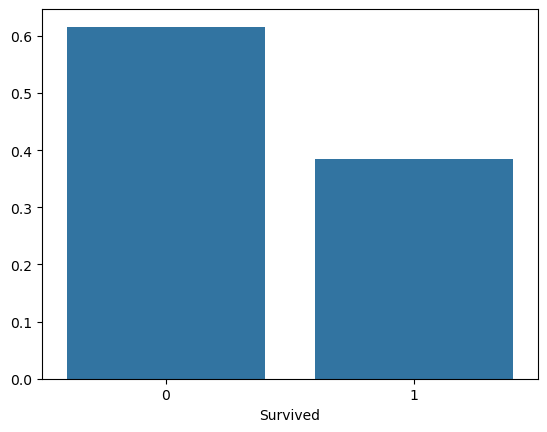

In [9]:
normalized = train_data['Survived'].value_counts(normalize=True)
sns.barplot(x=normalized.index, y=normalized.values);

Мы видим некоторый дисбаланс (приблизительно 62% на 38%), однако этот дисбаланс не настолько сильный, чтобы о нем беспокоиться. Можно сказать, что наши классы сбалансированы.

Пока что мы покончим с нашим анализом данных. Предлагаю не тянуть и перейти к построению baseline модели. Модель у нас будет, как водится, линейная, а точнее, логистическая регрессия.

# 2. Baseline: логистическая регрессия.

Логистическую регрессию будем строить при помощи моего любимого пакета statsmodels. Великолепное сочетание колоссального инструментария и донельзя запутанной документации делает работу с этим пакетом воистину захватывающей.

In [10]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + Parch + Fare + C(Embarked)'

model = logit(formula=formula, data=train_data)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.440539
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Survived         Pseudo R-squared: 0.338     
Date:               2024-06-23 14:17 AIC:              805.0398  
No. Observations:   891              BIC:              852.9633  
Df Model:           9                Log-Likelihood:   -392.52   
Df Residuals:       881              LL-Null:          -593.33   
Converged:          1.0000           LLR p-value:      6.1948e-81
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         4.0642   0.4728   8.5957 0.0000  3.1375  4.9909
C(Pclass)[T.2]   -0.9195   0.2973  -3.0925 0.0020 -1.5022 -0.3367


Прежде всего нам следует обратить внимание на значения в столбце, озаглавленном как "P>|z|". Значения, представленные в этом столбце, - это p-значения, для статистического теста, проверяющего равенство коэффициента при данном признаке нулю. В качестве порогового значения для данного теста мы возьмем классические 0.05. Мы видим, что данный тест не проходят признаки "Embarked", "Parch" и "Fare", и если первые 2 признака не вызывают особых вопросов, то крайне маловероятно, что признак "Fare" (т.е. цена билета) не влияет на целевой признак. Вполне вероятно, что связь есть, но она имеет нелинейный характер. Предлагаю в качестве признака взять логарифм цены (вот и всплыла та идея о преобразовании значений, которую мы так недавно брали на заметку).

In [11]:
formula = 'Survived ~ C(Pclass) + C(Sex) + Age + SibSp + np.log1p(Fare)'

model = logit(formula=formula, data=train_data)
results = model.fit()
print(results.summary2())

Optimization terminated successfully.
         Current function value: 0.440797
         Iterations 6
                         Results: Logit
Model:              Logit            Method:           MLE       
Dependent Variable: Survived         Pseudo R-squared: 0.338     
Date:               2024-06-23 14:17 AIC:              799.5003  
No. Observations:   891              BIC:              833.0467  
Df Model:           6                Log-Likelihood:   -392.75   
Df Residuals:       884              LL-Null:          -593.33   
Converged:          1.0000           LLR p-value:      1.5783e-83
No. Iterations:     6.0000           Scale:            1.0000    
-----------------------------------------------------------------
                  Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------
Intercept         2.6355   0.7164   3.6790 0.0002  1.2315  4.0395
C(Pclass)[T.2]   -0.8069   0.3092  -2.6100 0.0091 -1.4129 -0.2010


Итак, все отобранные нами признаки теперь проходят тест на значимость. Также стоит отметить, что значения критериев AIC и BIC понизились относительно предыдущей модели, а это означает, что внесенные нами изменения пошли модели на пользу. В целом, мы получили адекватную модель.

За что я люблю линейные модели? За интерпретируемость коэффициентов! Отрицательный коэффициент указывает на обратную зависимость между обучающим и целевым признаком, положительный - на прямую. Так, мы видим, что пассажиры 2-го класса выживают меньше, 3-го класса и подавно. Мужчин выжило меньше, большой возраст и наличие братьев, сестер или супругов на борту также препятствует выживанию. Зато чем выше цена билета, тем больше вероятность выжить. В целом, картина логична и здравому смыслу не противоречит.

Также мы могли бы рассмотреть наличие в наших данных взаимосвязей между признаками (например, рассмотреть, как влияют на выживаемость сочетание пола и класса и т.п.), но с учетом того, что далее мы будем применять более сложные модели, способные к нахождению подобных связей, я считаю, это будет излишним.

Теперь построим модель логистической регрессии при помощи библиотеки scikit-learn и посмотрим на метрику accuracy. Для этого мы заново загрузим наши данные, удалим бесполезные признаки, а всю предобработку данных (заполнение пропусков и кодирование) будем производить в пайплайне предобработки.

In [12]:
# заново загружаем данные и удаляем бесполезные признаки
train_data = pd.read_csv('data/train.csv')
test_data = pd.read_csv('data/test.csv')

train_data = train_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])
test_data = test_data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin'])

# логарифмируем признак 'Fare'
train_data['Fare'] = np.log1p(train_data['Fare'])
test_data['Fare'] = np.log1p(test_data['Fare'])

# производим бинарную кодировку признака "Sex"
train_data['Sex'] = train_data['Sex'].apply(lambda x: 0 if x == 'female' else 1)
test_data['Sex'] = test_data['Sex'].apply(lambda x: 0 if x == 'female' else 1)

# выделяем матрицу признаков и целевой вектор
X_train = train_data.drop(columns='Survived')
y_train = train_data['Survived']

# выделяем избранные признаки
selected_features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Fare']

# пишем пайплайн предобработки
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median'))
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])
transformers = [
    ('num', num_pipe, ['Age', 'Fare']),
    ('cat', cat_pipe, ['Pclass'])
]

column_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)

# пишем пайплайн обучения
log_regr_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('model', LogisticRegression(random_state=42, n_jobs=-1))
])

# задаем сетку гиперпараметров
param_grid = [
    {'model__penalty': [None]},
    {'model__penalty': ['l2'],
     'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]}
]

# задаем блоки перекрестной проверки
folds = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

# создаем модель поиска по сетке
log_regr_grid = GridSearchCV(
    log_regr_pipeline,
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=folds)

# обучаем модель
log_regr_grid.fit(X_train[selected_features], y_train)

# выводим лучшую метрику и лучшие значения гиперпараметров
print(f'Best score (accuracy): {np.round(log_regr_grid.best_score_, 3)}')
print(f'Best params: {log_regr_grid.best_params_}')

Best score (accuracy): 0.793
Best params: {'model__C': 0.1, 'model__penalty': 'l2'}


Мы получили неплохой результат. Не поражающий воображение, но, как минимум, неплохой. Давайте посмотрим на матрицу ошибок на обучающей выборке. Для большей ясности воспользуемся относительными значениями, т.е. долями.

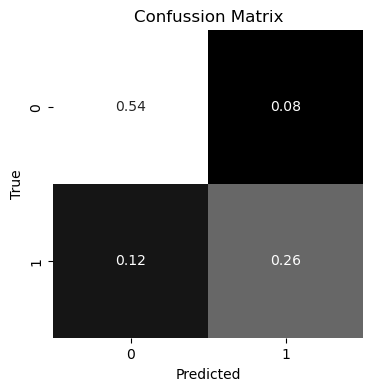

In [13]:
# делаем прогноз
y_pred = log_regr_grid.predict(X_train[selected_features])

# создаем матрицу ошибок
conf_matrix = confusion_matrix(y_train, y_pred, normalize='all')

# визуализируем матрицу ошибок
plt.figure(figsize = (4, 4))
plt.title('Confussion Matrix')
sns.heatmap(conf_matrix, cmap='gray', annot=True, fmt='.2f', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted');

Мы видим, что ошибки, в общем и целом, распределены равномерно. Есть небольшой перекос в сторону ложноотрицательных ошибок, однако он не является ярко выраженным.

Теперь посмотрим на отчет о классификации для обучающего набора данных.

In [14]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.87      0.84       549
           1       0.77      0.69      0.73       342

    accuracy                           0.80       891
   macro avg       0.79      0.78      0.78       891
weighted avg       0.80      0.80      0.80       891



Видно, что нашей модели легче дается прошнозирование класса 0, нежели класса 1, и если значение метрики precision для обоих классов примерно одинаково, то расхождение в метрике recall сразу бросается в глаза.

Я считаю, что мы достаточно подробно рассмотрели модель логистической регрессии для данного набора данных. Мы получили адекватную и вполне рабочую модель. Но мы, конечно же, на ней не остановимся и рассмотрим несколько альтернативных моделей.

# 3. Альтернативная модель №1: SVM.

Признаюсь, я люблю метод опорных векторов: этот метод способен находить нелинейные связи между признаками и, на моей скудной практике, часто показывает хороший результат. Для обучения этой модели мы будем использовать все доступные нам признаки, а не только те, что мы отобрали на этапе построения модели логистической регрессии, так как набор признаков, являющийся оптимальным для одной модели, может быть неоптимальным для другой.

In [15]:
# пишем пайплайн предобработки
num_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(drop='first'))
])
transformers = [
    ('num', num_pipe, ['Age', 'Fare']),
    ('cat', cat_pipe, ['Pclass', 'Embarked'])
]

column_transformer = ColumnTransformer(transformers=transformers, remainder='passthrough', n_jobs=-1)

# пишем пайплайн обучения
svc_pipeline = Pipeline([
    ('preprocess', column_transformer),
    ('model', SVC(random_state=42))
])

# задаем сетку гиперпараметров
param_grid = {
     'model__C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}


# создаем модель поиска по сетке
svc_grid = GridSearchCV(
    svc_pipeline,
    param_grid,
    scoring='accuracy',
    n_jobs=-1,
    cv=folds)

# обучаем модель
svc_grid.fit(X_train, y_train)

# выводим лучшую метрику и лучшие значения гиперпараметров
print(f'Best score (accuracy): {np.round(svc_grid.best_score_, 3)}')
print(f'Best params: {svc_grid.best_params_}')

Best score (accuracy): 0.819
Best params: {'model__C': 1}


Среднее значение метрики на валидационных наборах данный заметно выше, чем на baseline модели. Предлагаю точно так же посмотреть на матрицу ошибок и отчет о классификации для обучающего набора данных.

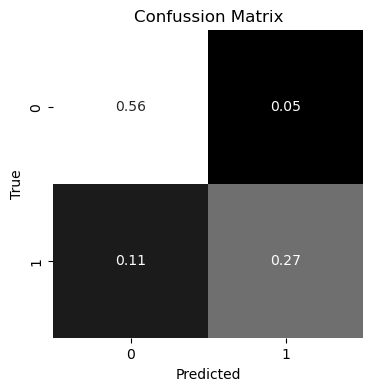

In [16]:
# делаем прогноз
y_pred = svc_grid.predict(X_train)

# создаем матрицу ошибок
conf_matrix = confusion_matrix(y_train, y_pred, normalize='all')

# визуализируем матрицу ошибок
plt.figure(figsize = (4, 4))
plt.title('Confussion Matrix')
sns.heatmap(conf_matrix, cmap='gray', annot=True, fmt='.2f', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted');

Здесь мы уже видим более явный перекос в сторону ложноотрицательных ошибок, однако сами доли ошибок ниже, чем в предыдущей модели.

In [17]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87       549
           1       0.83      0.72      0.77       342

    accuracy                           0.84       891
   macro avg       0.84      0.81      0.82       891
weighted avg       0.84      0.84      0.83       891



Картина приблизительно та же: практически идентичные значения метрики precision и разительно отличающиеся значения метрики recall. Все-таки дисбаланс классов 62/38 дает о себе знать.

# 4. Альтернативная модель №2: LightGBM.

Если SVM я люблю, то LightGBM я обожаю: простая, быстрая и мощная модель. Документация - мое почтение.

Производить подбор гиперпараметров будем с помощью библиотеки optuna.

In [18]:
# поменяем тип данных категориальных признаков на тип "category"
cat_cols = ['Pclass', 'Sex', 'Embarked']
X_train[cat_cols] = X_train[cat_cols].astype('category') 

# создадим словарь для результатов
result_dict = {
    'n_estimators': [],
    'learning_rate': [],
    'num_leaves': [],
    'reg_alpha': [],
    'reg_lambda': [],
    'logloss_mean': [],
    'logloss_std': []
}

# определяем функцию для подбора гиперпараметров
def optuna_lgbm_class(trial):
    # сетка гиперпараметров модели
    learning_rate = trial.suggest_float('learning_rate', 0.001, 1, step=0.001)
    num_leaves = trial.suggest_int('num_leaves', 2, 32)
    reg = trial.suggest_categorical('reg', ['l1', 'l2', 'none'])
    if reg == 'l1':
        reg_alpha = 10 ** trial.suggest_int('reg_alpha', -3, 3)
        reg_lambda = 0
    elif reg == 'l2':
        reg_alpha = 0
        reg_lambda = 10 ** trial.suggest_int('reg_lambda', -3, 3)
    else:
        reg_alpha = 0
        reg_lambda = 0
    
    # проверка на повторяющийся эксперимент
    # (если эксперимент с такими гиперпараметрами уже проводился, то просто
    # возвращаем предыдущий результат, ничего не вычисляя)
    for previous_trial in trial.study.trials:
        if previous_trial.state == optuna.trial.TrialState.COMPLETE and trial.params == previous_trial.params:
            return previous_trial.value

        
    # формируем обучающий датасет
    lgbm_train_set = Dataset(X_train, y_train, categorical_feature=cat_cols)

    # параметры модели
    params = {
        'objective': 'binary',
        'num_leaves': num_leaves,
        'learning_rate': learning_rate,
        'min_child_samples': 10,
        'subsample': 0.67,
        'reg_alpha': reg_alpha,
        'reg_lambda': reg_lambda,
        'random_state': 42,
        'n_jobs': -1,
        'force_col_wise': True,
        'verbosity': -1
    }

    # кросс-валидация
    results = lgbm_cv(
        params=params,
        train_set=lgbm_train_set,
        num_boost_round=100,
        folds=folds,
        metrics='binary_logloss',
        callbacks=[early_stopping(10, verbose=False)]
    )

    # вычисляем средние показатели значений функции потерь
    logloss_mean = results['valid binary_logloss-mean'][-1]
    logloss_std = results['valid binary_logloss-stdv'][-1]

    # заполняем словарь для результатов
    result_dict['n_estimators'].append(len(results['valid binary_logloss-mean']))
    result_dict['learning_rate'].append(learning_rate)
    result_dict['num_leaves'].append(num_leaves)
    result_dict['reg_alpha'].append(reg_alpha)
    result_dict['reg_lambda'].append(reg_lambda)
    result_dict['logloss_mean'].append(logloss_mean)
    result_dict['logloss_std'].append(logloss_std)

    # возвращаем значение оптимизируемой функции
    return logloss_mean

# производим подбор
study = optuna.create_study(study_name="LGBMClassifier",
                            direction="minimize",
                            sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(optuna_lgbm_class, n_trials=500, show_progress_bar=True)

# выводим лучшие значения гиперпараметров
best_params = study.best_params
print(f'Наилучшие значения гиперпараметров {best_params}')

  0%|          | 0/500 [00:00<?, ?it/s]

Наилучшие значения гиперпараметров {'learning_rate': 0.325, 'num_leaves': 14, 'reg': 'l2', 'reg_lambda': 1}


Посмотрим на топ 5 лучших наборов гиперпараметров.

In [19]:
pd.DataFrame(result_dict).sort_values('logloss_mean').head()

,n_estimators,learning_rate,num_leaves,reg_alpha,reg_lambda,logloss_mean,logloss_std
272,16,0.325,14,0.0,10.0,0.412189,0.033225
357,28,0.230,23,0.0,10.0,0.412257,0.035308
226,17,0.327,13,0.0,10.0,0.412325,0.035017
110,21,0.310,17,0.0,10.0,0.412363,0.035333
343,29,0.214,21,0.0,10.0,0.412381,0.034991


Видим, что лучший набор гиперпараметров превосходит остальные не только по среднему значению функции потерь, но и по стандартному отклонению (т.е. модель в среднем не только результативнее, но и стабильнее).

Обучим нашу модель и посмотрим на метрику accuracy.

In [20]:
lgbm_model = LGBMClassifier(
    objective='binary',
    n_estimators=16,
    learning_rate=0.325,
    num_leaves=14,
    min_child_samples=10,
    subsample=0.67,
    reg_alpha=0,
    reg_lambda=10,
    random_state=42,
    n_jobs=-1
)

results = cross_val_score(
    estimator=lgbm_model,
    X=X_train,
    y=y_train,
    scoring='accuracy',
    cv=folds,
    n_jobs=-1
)

print(f'Best score (accuracy): {np.mean(results).round(3)}')

Best score (accuracy): 0.825


Мы получили результат чуть лучше, чем при использовании SVM. Посмотрим на матрицу ошибок и отчет о классификации на тренировочном наборе данных.

In [21]:
# обучаем модель
lgbm_model.fit(X_train, y_train, categorical_feature=cat_cols)

[LightGBM] [Info] Number of positive: 342, number of negative: 549
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000276 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 224
[LightGBM] [Info] Number of data points in the train set: 891, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.383838 -> initscore=-0.473288
[LightGBM] [Info] Start training from score -0.473288


LGBMClassifier(learning_rate=0.325, min_child_samples=10, n_estimators=16,
               n_jobs=-1, num_leaves=14, objective='binary', random_state=42,
               reg_alpha=0, reg_lambda=10, subsample=0.67)

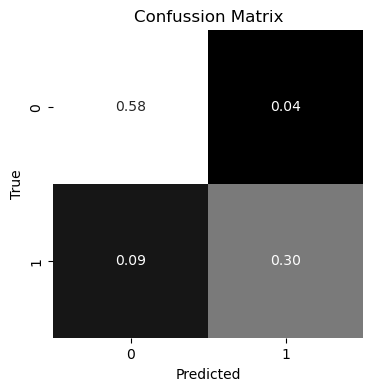

In [22]:
# делаем прогноз
y_pred = lgbm_model.predict(X_train)

# создаем матрицу ошибок
conf_matrix = confusion_matrix(y_train, y_pred, normalize='all')

# визуализируем матрицу ошибок
plt.figure(figsize = (4, 4))
plt.title('Confussion Matrix')
sns.heatmap(conf_matrix, cmap='gray', annot=True, fmt='.2f', cbar=False)
plt.ylabel('True')
plt.xlabel('Predicted');

In [23]:
print(classification_report(y_train, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.93      0.90       549
           1       0.88      0.77      0.82       342

    accuracy                           0.87       891
   macro avg       0.87      0.85      0.86       891
weighted avg       0.87      0.87      0.87       891



Картина аналогичная тем, что мы видели раньше.

Посмотрим на график важности признаков.

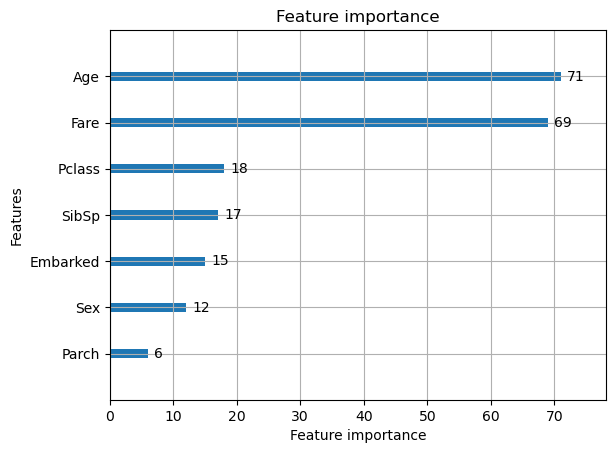

In [25]:
lgbm_plot_importance(lgbm_model);

По графику мы видим, что по степени важности с сильным отрывом лидируют 2 признака: "Age"  и "Fare" (не забываем, что мы используем логарифм цены, а не саму цену). Признак "Parch" оказался самым неинформативным (вспоминаем, что в baseline-модели нам вообще пришлось его удалить). Признак "Embarked", который нам так же пришлось удалить, занял третье место с конца. Удивительно, что второе место с конца занял признак "Sex" - честно говоря, я ожидал, что этот признак будет в тройке лидиров по степени информативности, ведь всем известно, что при катастрофах первыми спасают женщин и детей. По этому вопросу у меня есть целый ряд предположений, который я вам предлагаю сейчас проверить.

Предположение №1: женщин в целом было меньше, чем мужчин, так что и спаслось их меньше.

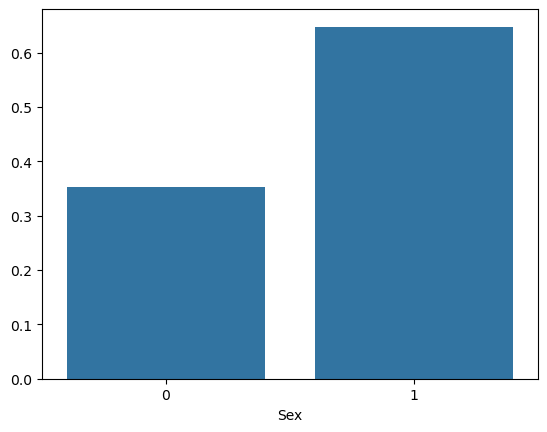

In [26]:
normalized = train_data['Sex'].value_counts(normalize=True)
sns.barplot(x=normalized.index, y=normalized.values);

Это действительно так: соотношение женщин к мужчинам на корабле составляет приблизительно 1 к 3.

Предположение №2: дети на корабле были преимущественно мужского пола.

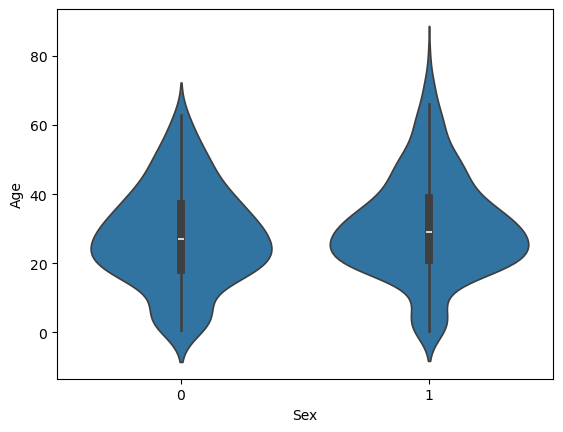

In [27]:
sns.violinplot(train_data, x='Sex', y='Age');

Это не так: мы видим, что среди детей девочек было больше, чем мальчиков.

Предположение №3: женщины, как правило, путешествовали по дешевым билетам.

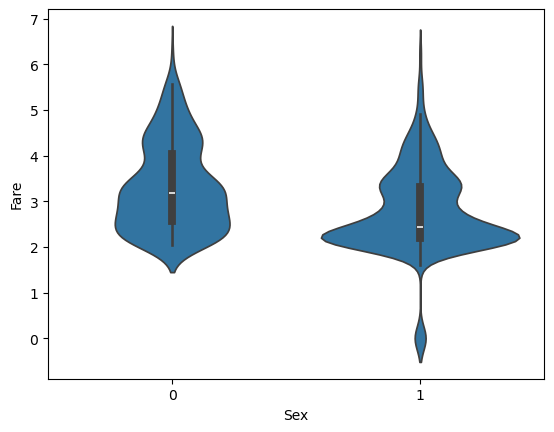

In [28]:
sns.violinplot(train_data, x='Sex', y='Fare');

Это не так.

И, пожалуй, последнее предположение №4: доля спасенных женщин зависит от класса.

Построим простую табличку: строки - класс, столбцы - пол, значения - доля выживших представителей данного пола в данном классе.

In [34]:
pd.crosstab(
    index=train_data['Pclass'],
    columns=train_data['Sex'],
    values=train_data['Survived'],
    aggfunc=np.mean
).round(2)

Sex,0,1
Pclass,,
1,0.97,0.37
2,0.92,0.16
3,0.50,0.14


Все-таки женщин спасали в первую очередь во всех трех классах, однако модель, по какой-то причине, не придала этому признаку такой большой степени значимости, как лично я от нее ожидал. Что ж, мне остается только развести руками.

# 5. Прогноз на тестовых данных.

Дело осталось за малым: сделать прогноз на тестовых данных, загрузить ответы в Kaggle и проверить результат. Думаю, не стоит объяснять, что в качестве рабочей модели мы выбираем последнюю модель.

In [35]:
test_data[cat_cols] = test_data[cat_cols].astype('category') 
test_pred = lgbm_model.predict(test_data)

Итак, после долгого бодания с kaggle'ом, который целых полтора часа выдавал мне различные ошибки при попытке закоммитить решение, я наконец-то добился своего и получил результат.

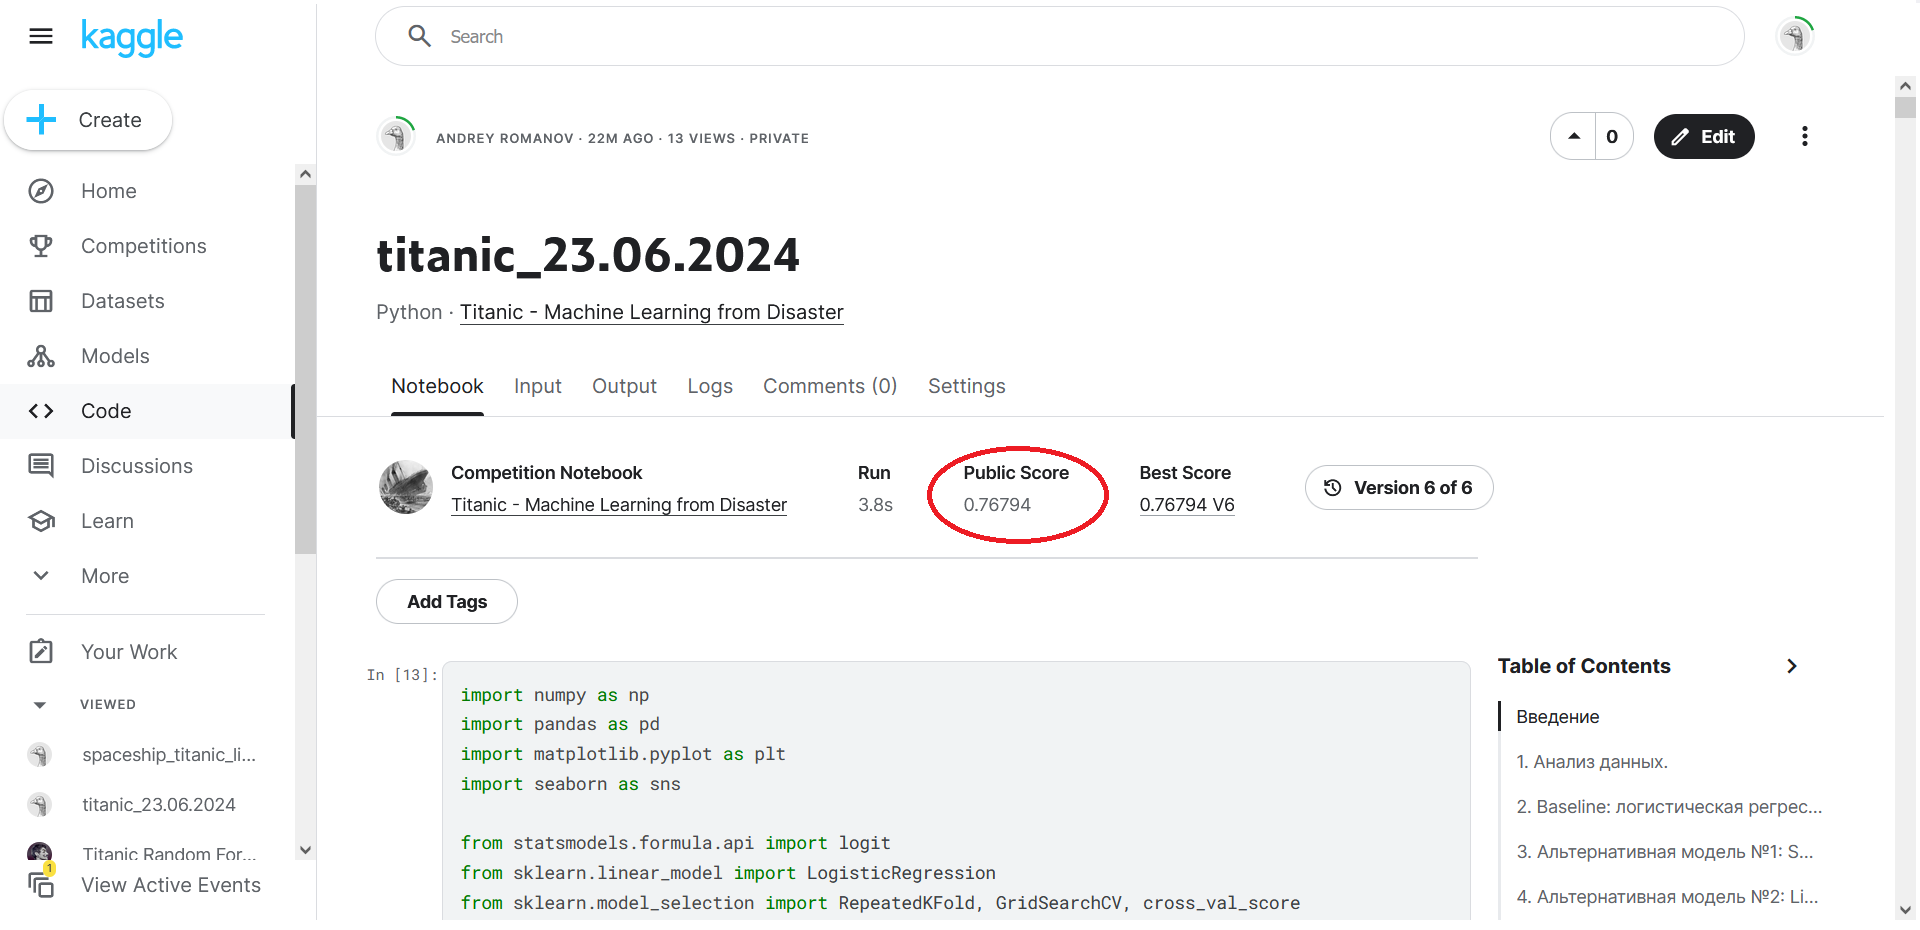

Признаюсь честно, результат ниже, чем я ожидал (я надеялся на 0,78-0,80), но я не готов тратить время на лишние 2-3% accuracy, так что оставлю все как есть.